In [1]:
import pickle
import pandas as pd
import numpy as np
from zipfile import ZipFile
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import string

In [3]:
sb.set_style('white')
sb.set(font_scale=2)

In [4]:
with ZipFile('../data/train.csv.zip') as z:
    with z.open('train.csv') as f:
        train_df = pd.read_csv(f)

In [5]:
with ZipFile('../data/test.csv.zip') as z:
    with z.open('test.csv') as f:
        test_df = pd.read_csv(f)

In [6]:
joint_df = pd.concat((train_df, test_df))

In [7]:
del train_df, test_df

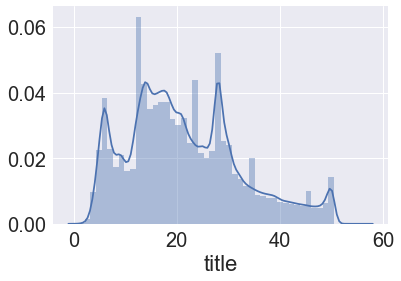

In [4]:
sb.distplot(train_df['title'].str.len())

In [5]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])

In [8]:
punct = set(string.punctuation)

In [9]:
train_df['puncts'] = train_df['title'].apply(lambda X: sum([1 for x in X if x in punct]))

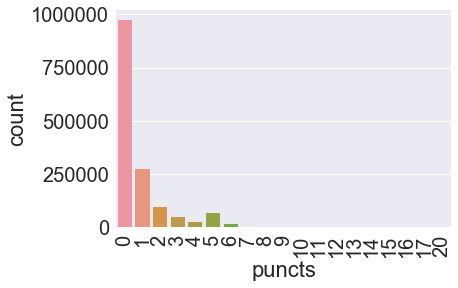

In [10]:
sb.countplot(train_df['puncts'])
plt.xticks(rotation=90);

In [8]:
from nltk import bigrams, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from collections import Counter

In [9]:
stop_en = stopwords.words('english')
stop_ru = stopwords.words('russian')
stop = set(stop_en + stop_ru)
stop |= set([
    'м', 'эт', 'м²', 'сот', 'р', 'в', 'т', 'д',
])

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
import re
from pymorphy2 import MorphAnalyzer

In [12]:
token_re = re.compile(r'[0-9]*[^\W\d]+[0-9]*')
ma = MorphAnalyzer()

In [19]:
def tokenizer(text):
    tokens = token_re.findall(text)
    tokens = [ma.normal_forms(x)[0] for x in tokens]
    return tokens

In [16]:
tfv = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop, max_features=7000,
                      ngram_range=(1, 2), token_pattern=r'[0-9]*[^\W\d]+[0-9]*')

In [17]:
tfidf = tfv.fit_transform(joint_df['title'])

In [22]:
from sklearn.decomposition import NMF

In [23]:
nmf = NMF(n_components=20)

In [24]:
comp20 = nmf.fit_transform(tfidf)

In [35]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" - ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [36]:
print("Topics found via NMF:")
tfidf_feature_names = tfv.get_feature_names()
print_top_words(nmf, tfidf_feature_names, 10)

Topics found via NMF:

Topic #0:
квартира - снять квартира - снять - купить квартира - купить - ремонт квартира - ремонт - уборка - отделка - офис

Topic #1:
платье - свадебный - свадебный платье - продать платье - вечерний - платье девочка - новое платье - выпускной - платье новое - нарядный

Topic #2:
дом - дом участок - соты - участок соты - участок - дача - дача участок - коттедж - снять дом - коттедж участок

Topic #3:
продать - продать платье - продать куртка - продать коляска - продать детский - б - продать туфля - продать пальто - продать новый - телефон

Topic #4:
куртка - весна - демисезонный - куртка весна - кожаный - куртка демисезонный - осень - весна осень - кожаный куртка - продать куртка

Topic #5:
туфля - женский - туфля женский - продать туфля - кожаный - размер - кожа - новое туфля - туфля новое - туфля девочка

Topic #6:
ваза - samara - ваза samara - ваза око - око - хрустальный - ссср - цветок - ремонт - lada

Topic #7:
костюм - спортивный - спортивный костюм - дев

In [18]:
from scipy.sparse import save_npz

In [19]:
train_tfidf = tfidf[:1503424]

In [20]:
test_tfidf = tfidf[1503424:]

In [21]:
train_tfidf.shape

(1503424, 7000)

In [22]:
test_tfidf.shape

(508438, 7000)

In [23]:
with open('./text_features/train/title_tfidf_7000.npz', 'wb') as f:
    save_npz(f, train_tfidf)

In [24]:
with open('./text_features/test/title_tfidf_7000.npz', 'wb') as f:
    save_npz(f, test_tfidf)

In [25]:
with open('./text_features/title_tfidf_7000_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfv, f)

## BagOfWords

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

In [45]:
count_v = CountVectorizer(max_features=2000, max_df=0.9, min_df=2, ngram_range=(1, 2))

In [46]:
bof = count_v.fit_transform(joint_df['title'])

In [47]:
from scipy.sparse import save_npz

In [48]:
train_bof = tfidf[:1503424]

In [49]:
test_bof = tfidf[1503424:]

In [52]:
train_bof.shape

(1503424, 2000)

In [53]:
test_bof.shape

(508438, 2000)

In [54]:
with open('./text_features/train/title_bof.npz', 'wb') as f:
    save_npz(f, train_bof)

In [55]:
with open('./text_features/test/title_bof.npz', 'wb') as f:
    save_npz(f, test_bof)

In [56]:
with open('./text_features/title_bof_vectorizer.pkl', 'wb') as f:
    pickle.dump(count_v, f)